In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, TensorDataset
from sklearn.metrics import accuracy_score
import pandas as pd
import time
import os
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

In [2]:
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"


df_trainval = pd.read_csv(train_url, sep="\t", header=None, names=["sentence", "label"])
df_test = pd.read_csv(test_url, sep="\t", header=None, names=["sentence", "label"])

train_df, val_df = train_test_split(
    df_trainval,
    test_size=0.2,
    random_state=42,
    stratify=df_trainval["label"]
)

print("Train:", train_df.shape, "Val:", val_df.shape, "Test:", df_test.shape)


Train: (5536, 2) Val: (1384, 2) Test: (1821, 2)


In [3]:
vectorizer = CountVectorizer(
    lowercase=True,
    stop_words="english",
    max_features=10000
)

# Fit on training sentences and transform train/val/test
vectorizer.fit(train_df["sentence"])

X_train = vectorizer.transform(train_df["sentence"])
X_val   = vectorizer.transform(val_df["sentence"])
X_test  = vectorizer.transform(df_test["sentence"])

y_train = train_df["label"].values
y_val   = val_df["label"].values
y_test  = df_test["label"].values

print("X_train shape:", X_train.shape)

X_train shape: (5536, 10000)


In [4]:
X_train_dense = torch.tensor(X_train.toarray(), dtype=torch.float32)
X_val_dense   = torch.tensor(X_val.toarray(),   dtype=torch.float32)
X_test_dense  = torch.tensor(X_test.toarray(),  dtype=torch.float32)

y_train_t = torch.tensor(y_train, dtype=torch.long)
y_val_t   = torch.tensor(y_val,   dtype=torch.long)
y_test_t  = torch.tensor(y_test,  dtype=torch.long)

train_dataset = TensorDataset(X_train_dense, y_train_t)
val_dataset   = TensorDataset(X_val_dense,   y_val_t)
test_dataset  = TensorDataset(X_test_dense,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [5]:
class MLP(nn.Module):
    def __init__(self, input_size=X_train_dense.shape[1], hidden_sizes=[512, 256, 128, 64], num_classes=2):
        super().__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        layers.append(nn.Linear(in_size, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

model = MLP()
print(f"Trainable Parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")


Trainable Parameters: 5293122


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_acc = 0
train_acc_list, val_acc_list, val_loss_list = [], [], []

for epoch in range(10):
    model.train()
    correct, total = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)
    train_acc_list.append(correct / total)

    model.eval()
    with torch.no_grad():
        correct, total, val_loss = 0, 0, 0
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            out = model(x)
            loss = criterion(out, y)
            val_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        acc = correct / total
        val_loss_list.append(val_loss / len(val_loader))
        val_acc_list.append(acc)
        if acc > best_acc:
            torch.save(model.state_dict(), "checkpoint.pt")
            best_acc = acc


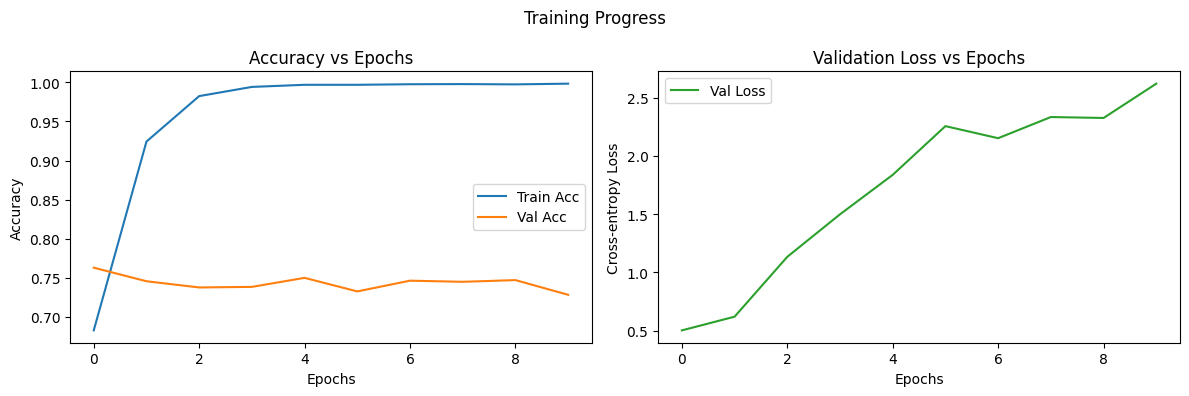

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# accuracy
ax1.plot(train_acc_list, label="Train Acc",  color="tab:blue")
ax1.plot(val_acc_list,   label="Val Acc",    color="tab:orange")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.set_title("Accuracy vs Epochs")
ax1.legend()

# validation loss
ax2.plot(val_loss_list, label="Val Loss", color="tab:green")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Cross‑entropy Loss")
ax2.set_title("Validation Loss vs Epochs")
ax2.legend()

plt.suptitle("Training Progress")
plt.tight_layout()
plt.show()


In [8]:
model.load_state_dict(torch.load("checkpoint.pt"))
model.eval()
quant_model = torch.quantization.quantize_dynamic(model, {nn.Linear}, dtype=torch.qint8)
torch.save(quant_model.state_dict(), "quant_model.pt")


In [9]:
half_model = MLP().half().to(device)
half_model.load_state_dict(torch.load("checkpoint.pt"))
torch.save(half_model.state_dict(), "Half.pt")

In [10]:
def evaluate(model, name="Original", half=False):
    model.eval()
    correct, total = 0, 0
    start = time.time()
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            if half:
                x = x.half()
            out = model(x)
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
    end = time.time()
    size_mb = os.path.getsize(f"{name}.pt") / 1e6
    print(f"{name:<12} | Accuracy: {100*correct/total:6.2f}% | Time: {((end-start)*1000):7.2f} ms | Size: {size_mb:5.2f} MB")
    return 100*correct/total, (end-start)*1000, size_mb

torch.save(model.state_dict(), "Original.pt")

evaluate(model, "Original")
evaluate(quant_model, "quant_model")
evaluate(half_model, "Half", half=True)

Original     | Accuracy:  79.52% | Time:  451.98 ms | Size: 21.18 MB
quant_model  | Accuracy:  79.52% | Time:  284.73 ms | Size:  5.30 MB
Half         | Accuracy:  79.52% | Time: 1793.65 ms | Size: 10.59 MB


(79.51674903898957, 1793.6513423919678, 10.589454)